In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ballsss/B014YN7LVE_data.jsonl
/kaggle/input/ballsss/B00R92CL5E_data.jsonl
/kaggle/input/ballsss/B0053DDNW6_data.jsonl


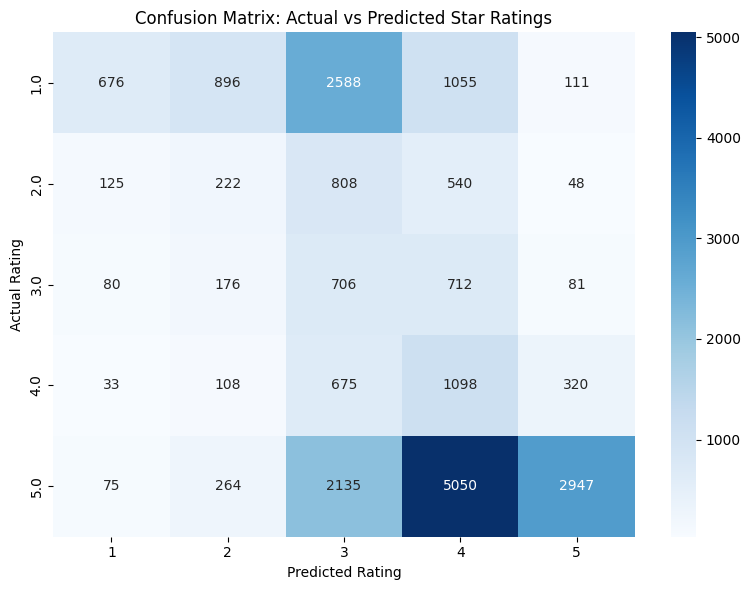

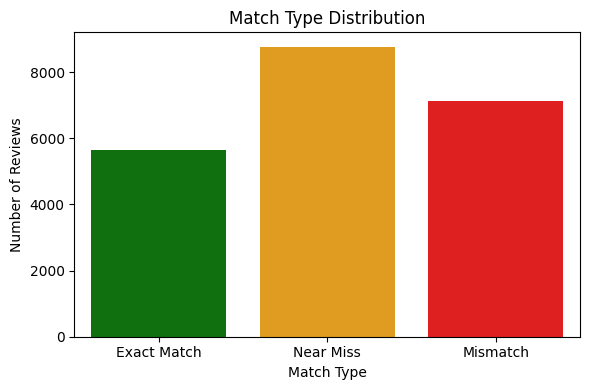

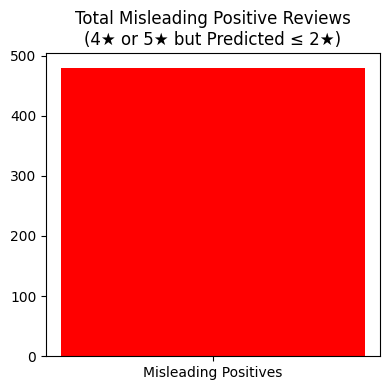

,text,rating,simulated_rating,misleading_positive,match_type
0,Works great in my condo. Had a lot of trouble...,5.0,4,False,Near Miss
1,Didn’t notice any difference,4.0,3,False,Near Miss
2,This item was purchased new and once I opened ...,1.0,4,False,Mismatch
3,"Does its job,",4.0,3,False,Near Miss
4,It's been working perfectly for months now. It...,5.0,5,False,Exact Match
5,Completely unnecessary and overcomplicated. No...,1.0,2,False,Near Miss
6,I totally love the fact that it works with no ...,5.0,5,False,Exact Match
7,product is great,5.0,5,False,Exact Match
8,Easy to set up.,5.0,4,False,Near Miss
9,"I can't use this, No Ethernet! I didn't realiz...",3.0,3,False,Exact Match


In [14]:
# ================================
# 📦 IMPORTS
# ================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# ================================
# 📥 LOAD DATA
# ================================
df1 = pd.read_json("/kaggle/input/ballsss/B00R92CL5E_data.jsonl", lines=True)
df2 = pd.read_json("/kaggle/input/ballsss/B014YN7LVE_data.jsonl", lines=True)
df1["asin"] = "B00R92CL5E"
df2["asin"] = "B014YN7LVE"
df = pd.concat([df1, df2], ignore_index=True)

df['text'] = df['text'].fillna("")
df['rating'] = df['rating'].astype(float)

# ================================
# ⭐ SIMULATED STAR RATING (BERT Proxy)
# ================================
def simulated_bert_rating(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity <= -0.3:
        return 1
    elif polarity <= -0.1:
        return 2
    elif polarity <= 0.1:
        return 3
    elif polarity <= 0.5:
        return 4
    else:
        return 5

df['simulated_rating'] = df['text'].apply(simulated_bert_rating)

# ================================
# 🚨 MISLEADING POSITIVE REVIEWS
# ================================
df['misleading_positive'] = df.apply(lambda x: x['rating'] >= 4 and x['simulated_rating'] <= 2, axis=1)

# ================================
# 🔍 MATCH TYPE LABEL
# ================================
def label_mismatch(row):
    if row['rating'] == row['simulated_rating']:
        return "Exact Match"
    elif abs(row['rating'] - row['simulated_rating']) == 1:
        return "Near Miss"
    else:
        return "Mismatch"

df['match_type'] = df.apply(label_mismatch, axis=1)

# ================================
# 📊 VISUALIZATION
# ================================

# 1. Confusion Matrix
conf_mat = pd.crosstab(df['rating'], df['simulated_rating'], rownames=["Actual Rating"], colnames=["Predicted Rating"])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Actual vs Predicted Star Ratings")
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.tight_layout()
plt.show()

# 2. Match Type Distribution
match_counts = df['match_type'].value_counts().reindex(['Exact Match', 'Near Miss', 'Mismatch'])

plt.figure(figsize=(6, 4))
sns.barplot(x=match_counts.index, y=match_counts.values, palette=["green", "orange", "red"])
plt.title("Match Type Distribution")
plt.ylabel("Number of Reviews")
plt.xlabel("Match Type")
plt.tight_layout()
plt.show()

# 3. Misleading Review Count
misleading_count = df['misleading_positive'].sum()

plt.figure(figsize=(4, 4))
plt.bar(["Misleading Positives"], [misleading_count], color='red')
plt.title("Total Misleading Positive Reviews\n(4★ or 5★ but Predicted ≤ 2★)")
plt.tight_layout()
plt.show()

# ================================
# 🧾 DISPLAY FINAL TABLE
# ================================
df[['text', 'rating', 'simulated_rating', 'misleading_positive', 'match_type']].head(20)


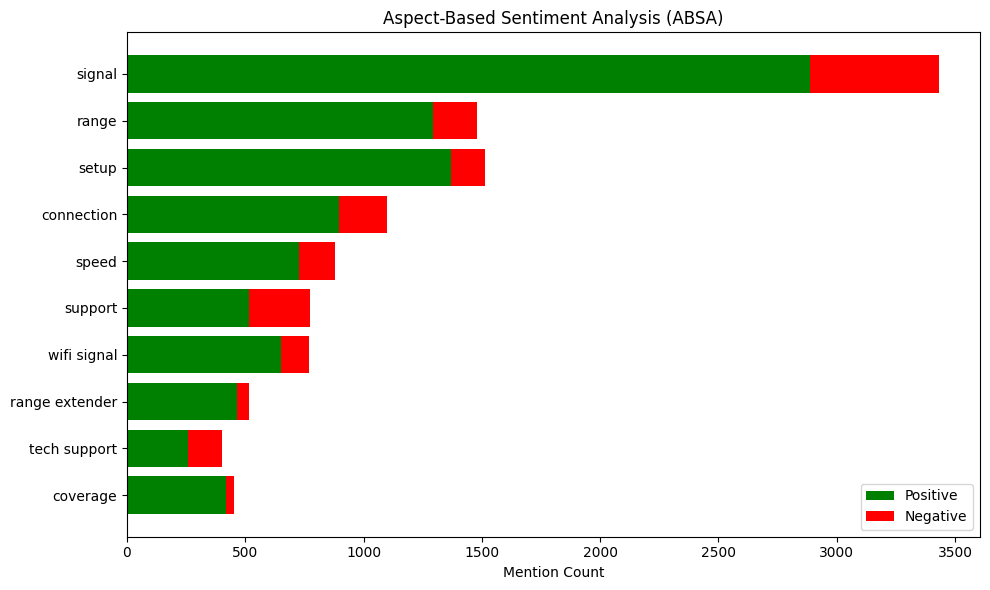

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Extract features
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=300, stop_words='english')
X = vectorizer.fit_transform(df['text'])
keywords = vectorizer.get_feature_names_out()

product_keywords = [
    "speed", "range", "setup", "connection", "signal", "support", "performance", 
     "antenna", "coverage", "interface", "installation", "reliability"
]
keyword_pool = [kw for kw in keywords if any(pk in kw for pk in product_keywords)]

# Use TextBlob polarity to assign sentiment
from textblob import TextBlob
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Build sentiment map for features
feature_sentiment = defaultdict(list)
for _, row in df.iterrows():
    text = row['text']
    polarity = row['polarity']
    for feat in keyword_pool:
        if feat in text.lower():
            if polarity > 0.1:
                feature_sentiment[feat].append("positive")
            elif polarity < -0.1:
                feature_sentiment[feat].append("negative")
            else:
                feature_sentiment[feat].append("neutral")

# Plot top features
from collections import Counter
top_features = Counter({k: len(v) for k, v in feature_sentiment.items()}).most_common(10)
labels, pos_counts, neg_counts = [], [], []

for feat, _ in top_features:
    counts = Counter(feature_sentiment[feat])
    labels.append(feat)
    pos_counts.append(counts.get("positive", 0))
    neg_counts.append(counts.get("negative", 0))

plt.figure(figsize=(10, 6))
plt.barh(labels, pos_counts, color="green", label="Positive")
plt.barh(labels, neg_counts, color="red", left=pos_counts, label="Negative")
plt.xlabel("Mention Count")
plt.title("Aspect-Based Sentiment Analysis (ABSA)")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()


Device set to use cuda:0


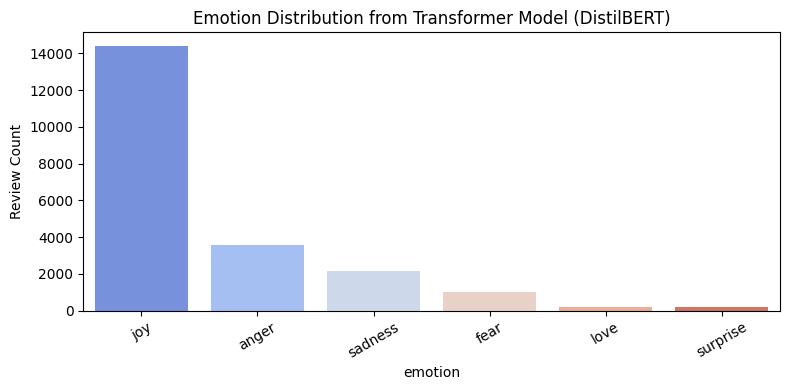

In [16]:

from transformers import pipeline
from tqdm import tqdm

# ✅ Step 2: Load the fast emotion classifier
emotion_pipeline = pipeline(
    "text-classification", 
    model="bhadresh-savani/distilbert-base-uncased-emotion", 
    top_k=1, 
    device=0  # Use GPU if available
)

# ✅ Step 3: Prepare batched input
tqdm.pandas()
texts = df['text'].fillna("").astype(str).tolist()
results = emotion_pipeline(texts, batch_size=32, truncation=True)

# ✅ Step 4: Assign top emotion to each row
df['emotion'] = [res[0]['label'] if res else None for res in results]

# ✅ Step 5: Visualize emotion distribution
import seaborn as sns
import matplotlib.pyplot as plt

emotion_counts = df['emotion'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="coolwarm")
plt.title("Emotion Distribution from Transformer Model (DistilBERT)")
plt.ylabel("Review Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

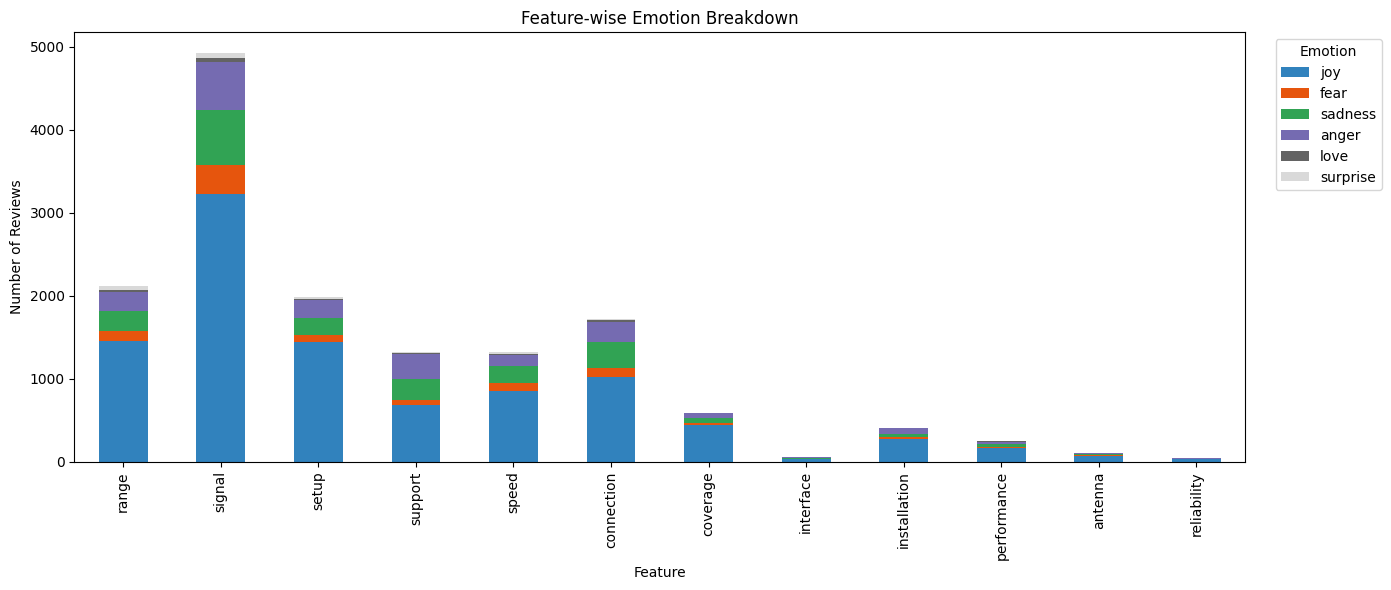

In [17]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd

# Use the features you extracted
features = ['speed', 'range', 'setup', 'connection', 'signal',
            'support', 'performance','antenna',
            'coverage', 'interface', 'installation', 'reliability']

# Create mapping
feature_emotion_map = defaultdict(Counter)

for _, row in df.iterrows():
    text = row['text'].lower()
    emotion = row['emotion']
    if not emotion:
        continue
    for feat in features:
        if feat in text:
            feature_emotion_map[feat][emotion] += 1

# Convert to DataFrame
feature_emotion_df = pd.DataFrame(feature_emotion_map).fillna(0).astype(int).T
feature_emotion_df = feature_emotion_df[feature_emotion_df.sum(axis=1) > 0]  # drop empty

# Plot stacked bar chart
feature_emotion_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap="tab20c")
plt.title("Feature-wise Emotion Breakdown")
plt.xlabel("Feature")
plt.ylabel("Number of Reviews")
plt.legend(title="Emotion", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
# Step 1: Define segmentation logic
def classify_segment(row):
    rating = row['rating']
    emotion = row['emotion']
    polarity = row['polarity']

    if rating >= 4 and emotion in ['joy', 'trust'] and polarity > 0:
        return "Loyal Promoter"
    elif rating == 3 and emotion in ['sadness', 'neutral', 'anticipation']:
        return "Silent Quitter"
    elif rating <= 2 and emotion in ['anger', 'disgust', 'fear']:
        return "Vocal Critic"
    else:
        return "Others"

# Step 2: Apply segmentation
df['segment'] = df.apply(classify_segment, axis=1)

# Step 3: Filter to 3 core segments
df_seg = df[df['segment'].isin(["Loyal Promoter", "Silent Quitter", "Vocal Critic"])]


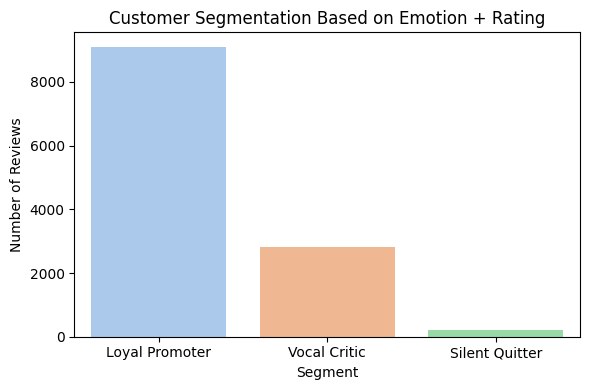

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

seg_counts = df_seg['segment'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=seg_counts.index, y=seg_counts.values, palette="pastel")
plt.title("Customer Segmentation Based on Emotion + Rating")
plt.ylabel("Number of Reviews")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()


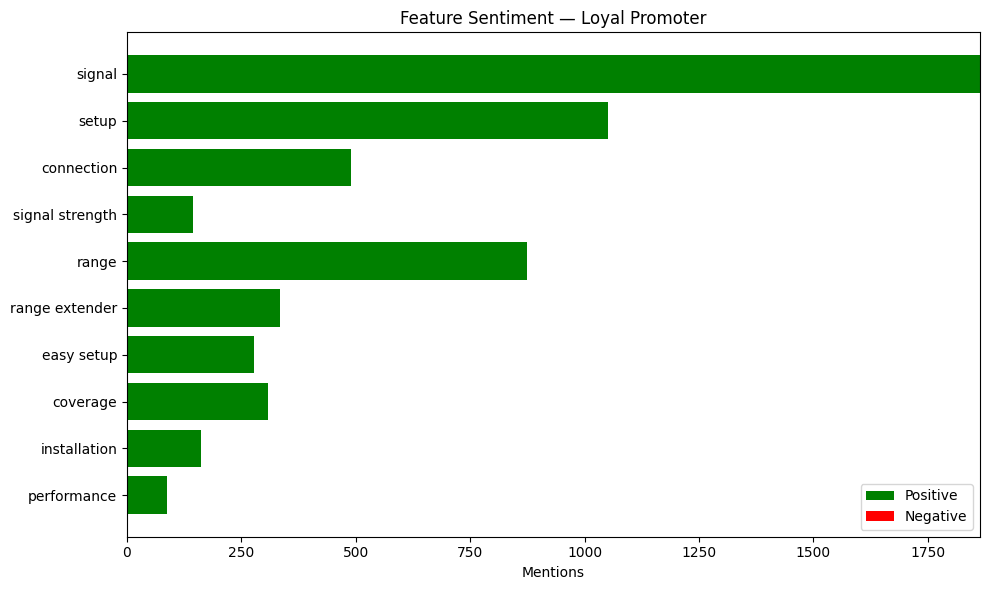

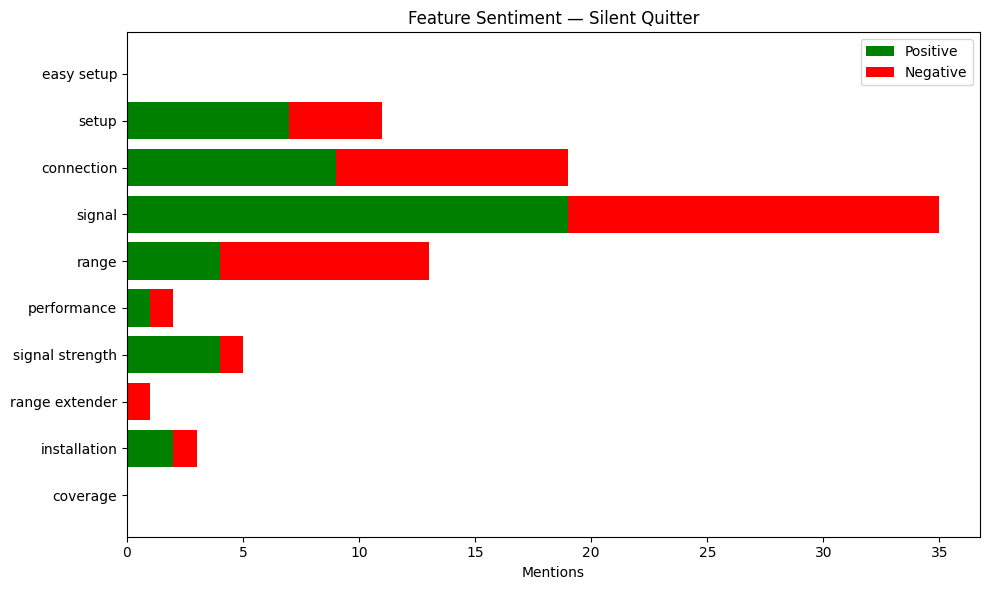

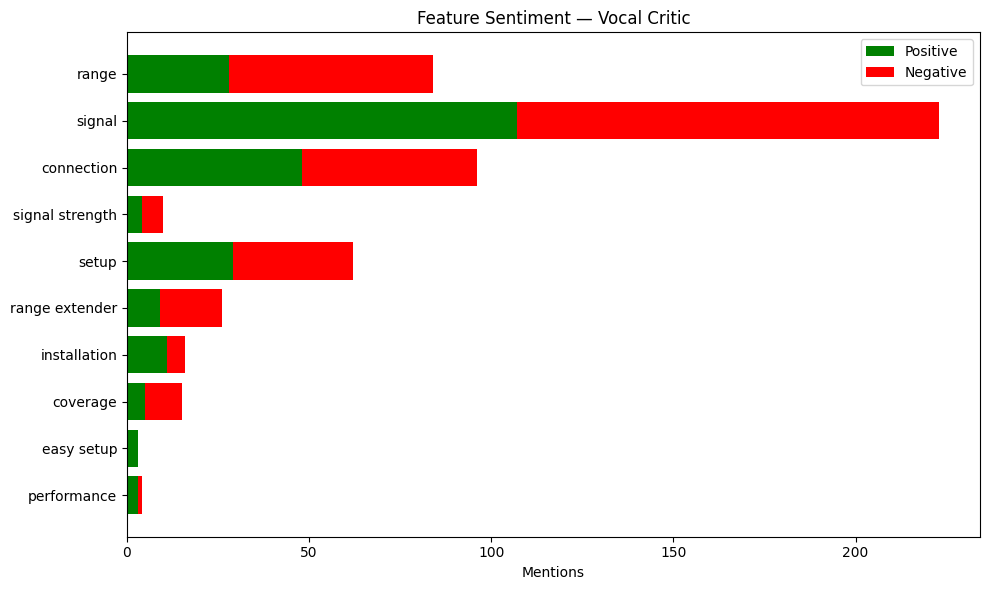

In [20]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Create a map: segment → feature → sentiment counter
segment_feature_sentiment = defaultdict(lambda: defaultdict(Counter))

for _, row in df.iterrows():
    text = row['text'].lower()
    segment = row['segment']
    polarity = row['polarity']

    if segment not in ["Loyal Promoter", "Silent Quitter", "Vocal Critic"]:
        continue

    for feat in keyword_pool[:10]:  # top 10 for clarity
        if feat in text:
            sentiment = "positive" if polarity > 0.1 else "negative" if polarity < -0.1 else "neutral"
            segment_feature_sentiment[segment][feat][sentiment] += 1

# Plot for each segment
for segment in ["Loyal Promoter", "Silent Quitter", "Vocal Critic"]:
    data = segment_feature_sentiment.get(segment, {})
    if not data:
        continue

    labels, pos_counts, neg_counts = [], [], []
    for feat, sentiments in data.items():
        labels.append(feat)
        pos_counts.append(sentiments.get("positive", 0))
        neg_counts.append(sentiments.get("negative", 0))

    plt.figure(figsize=(10, 6))
    plt.barh(labels, pos_counts, color="green", label="Positive")
    plt.barh(labels, neg_counts, left=pos_counts, color="red", label="Negative")
    plt.title(f"Feature Sentiment — {segment}")
    plt.xlabel("Mentions")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.tight_layout()
    plt.show()


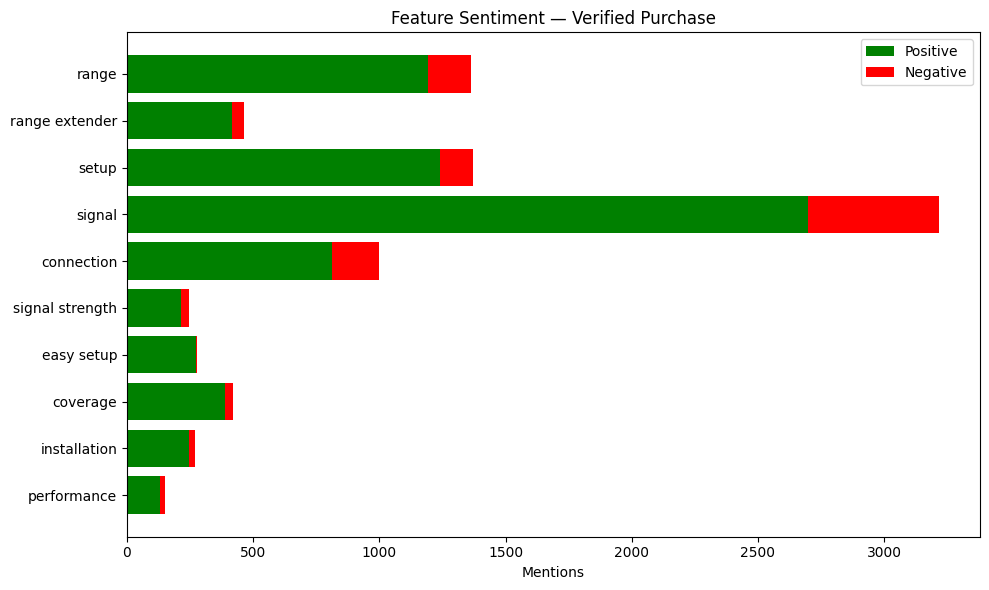

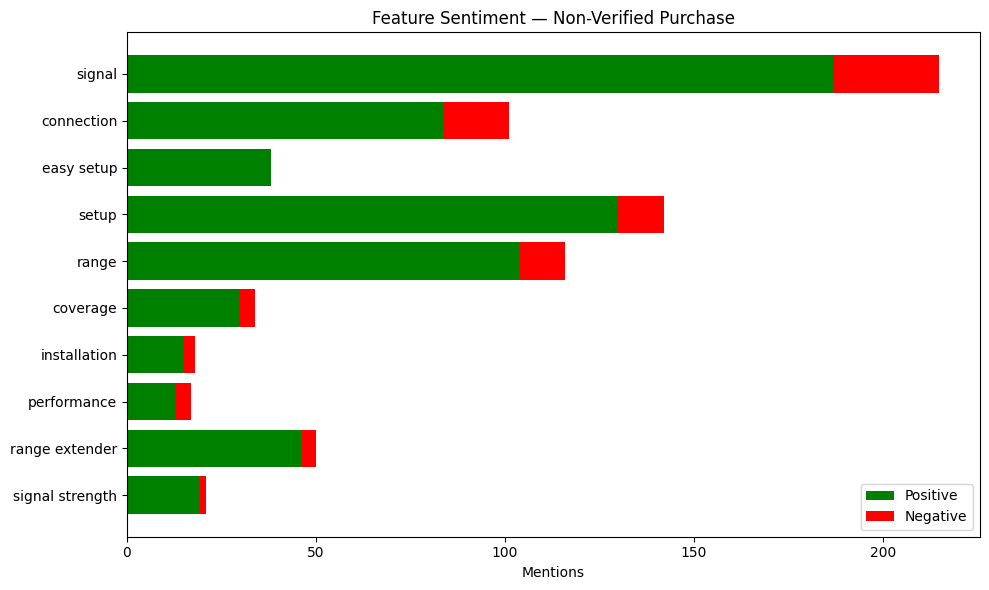

In [22]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Step 1: Create a human-readable label column
df['verified_label'] = df['verified_purchase'].apply(
    lambda x: "Verified Purchase" if x else "Non-Verified Purchase"
)

# Step 2: Create mapping: verified status → feature → sentiment
verified_feature_sentiment = defaultdict(lambda: defaultdict(Counter))

for _, row in df.iterrows():
    text = row['text'].lower()
    verified_status = row['verified_label']
    polarity = row['polarity']

    for feat in keyword_pool[:10]:  # use top 10 features for cleaner plots
        if feat in text:
            sentiment = "positive" if polarity > 0.1 else "negative" if polarity < -0.1 else "neutral"
            verified_feature_sentiment[verified_status][feat][sentiment] += 1

# Step 3: Plot sentiment bars for each group
for status in ["Verified Purchase", "Non-Verified Purchase"]:
    data = verified_feature_sentiment.get(status, {})
    if not data:
        continue

    labels, pos_counts, neg_counts = [], [], []
    for feat, sentiments in data.items():
        labels.append(feat)
        pos_counts.append(sentiments.get("positive", 0))
        neg_counts.append(sentiments.get("negative", 0))

    plt.figure(figsize=(10, 6))
    plt.barh(labels, pos_counts, color="green", label="Positive")
    plt.barh(labels, neg_counts, left=pos_counts, color="red", label="Negative")
    plt.title(f"Feature Sentiment — {status}")
    plt.xlabel("Mentions")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.tight_layout()
    plt.show()


In [31]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# ✅ Step 1: Convert and bucket helpful_vote
df['helpful_vote'] = pd.to_numeric(df['helpful_vote'], errors='coerce').fillna(0)
df['helpful_bucket'] = df['helpful_vote'].apply(lambda x: f"{int(x//10)*10}–{int(x//10)*10+9}")

# ✅ Step 2: Build feature-sentiment mapping for each helpful_vote bucket
bucket_feature_sentiment = defaultdict(lambda: defaultdict(Counter))

for _, row in df.iterrows():
    text = row['text'].lower()
    polarity = row['polarity']  # already computed using TextBlob earlier
    bucket = row['helpful_bucket']

    for feat in keyword_pool[:10]:  # use top 10 features
        if feat in text:
            sentiment = (
                "positive" if polarity > 0.1 else
                "negative" if polarity < -0.1 else
                "neutral"
            )
            bucket_feature_sentiment[bucket][feat][sentiment] += 1



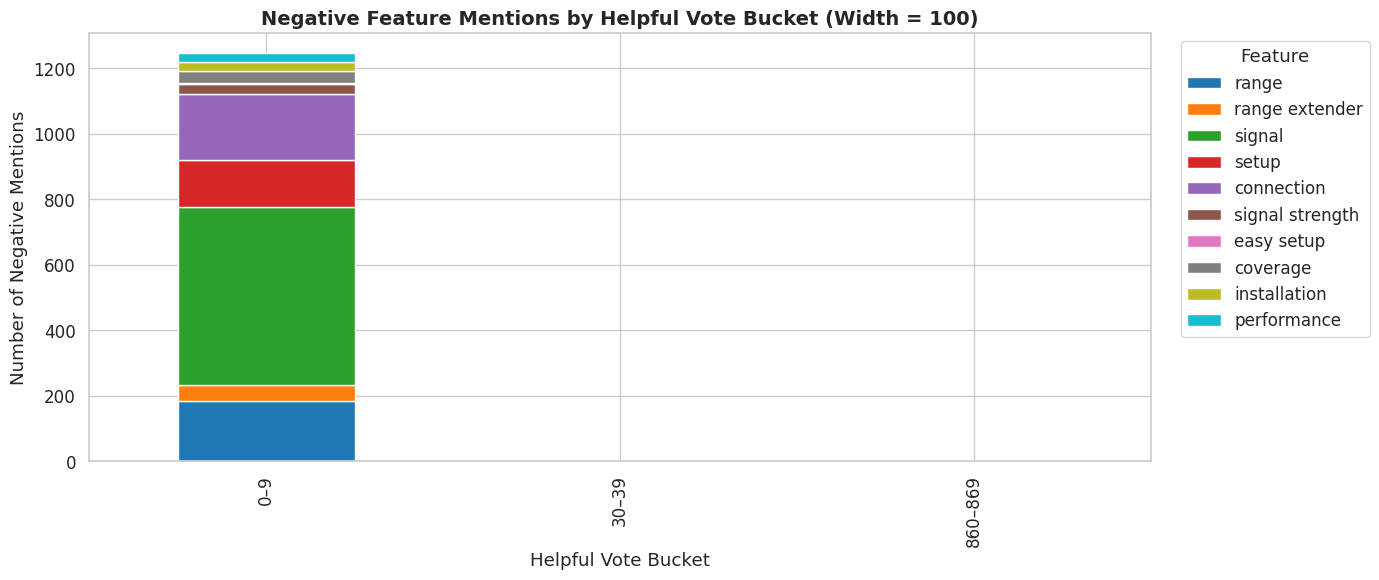

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Step 1: Re-bucket with width = 100
def bucket_100(votes):
    if votes < 100:
        return "0–99"
    elif votes < 200:
        return "100–199"
    elif votes < 300:
        return "200–299"
    elif votes < 400:
        return "300–399"
    elif votes < 500:
        return "400–499"
    elif votes < 600:
        return "500–599"
    elif votes < 700:
        return "600–699"
    elif votes < 800:
        return "700–799"
    elif votes < 900:
        return "800–899"
    else:
        return "900+"

df['helpful_bucket'] = df['helpful_vote'].apply(bucket_100)

# Step 2: Rebuild negative sentiment counts per feature per bucket
neg_data = defaultdict(dict)

for bucket, features in bucket_feature_sentiment.items():
    for feat, sentiments in features.items():
        if sentiments.get('negative', 0) > 0:
            neg_data[bucket][feat] = sentiments['negative']

# Step 3: Create DataFrame
neg_df = pd.DataFrame(neg_data).fillna(0).astype(int).T

# Sort bucket labels numerically
neg_df.index = pd.CategoricalIndex(
    neg_df.index,
    categories=sorted(neg_df.index, key=lambda x: int(x.split('–')[0].replace('+', '000'))),
    ordered=True
)
neg_df = neg_df.sort_index()

# Step 4: Plot
sns.set(style="whitegrid", font_scale=1.1)
neg_df.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab10')
plt.title("Negative Feature Mentions by Helpful Vote Bucket (Width = 100)", fontsize=14, fontweight="bold")
plt.xlabel("Helpful Vote Bucket")
plt.ylabel("Number of Negative Mentions")
plt.legend(title="Feature", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
